In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns

The goal of this notebook is for me to explore the take home users dataframe and determine what factors cause adoption. Adoption has been defined as users who have used the product at least three or more times within a seven day period. In order to determine these factors I will use the data in order to create features that express adoption and fit a machine learning algorithm that can model adoption. Through the model I should be able to identify features that indicate whether or not a user adopts the platform.

In [40]:
data = pd.read_csv('takehome_users.csv')
engagement = pd.read_csv('takehome_user_engagement.csv')

In [41]:
data.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [42]:
engagement.head(20)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
5,2013-12-31 03:45:04,2,1
6,2014-01-08 03:45:04,2,1
7,2014-02-03 03:45:04,2,1
8,2014-02-08 03:45:04,2,1
9,2014-02-09 03:45:04,2,1


The creation time variable was listed as an object. I used the datetime module to format it into an object and then created a new format that could be used as categories later on. I also transform the timestamp column of the engagement dataset. 

In [43]:
data['creation_time'] = (data['creation_time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')))

data['creation_date'] = data['creation_time'].apply(lambda x: str(x.month) + '-' + str(x.year))

engagement['time_stamp'] = engagement['time_stamp'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

The user_id column of the engagement index needs to be set as an object so that it won't aggregate while grouping. I also set the index of the engagement set as a time_stamp so that I can resample it by the week and aggregate by the amount of visits in each user's most frequently visited week.

In [46]:
engagement['user_id'] = engagement['user_id'].astype('O')

engagement = engagement.set_index('time_stamp')

engagement_max_week_visits = engagement.groupby(['user_id']).resample('W').sum().reset_index().sort_values('time_stamp').groupby(['user_id']).max()

engagement_max_week_visits.head()

,time_stamp,visited
user_id,,
1,2014-04-27,1
2,2014-04-06,3
3,2013-03-24,1
4,2013-05-26,1
5,2013-01-27,1


I merge the datasets so that each user in the main dataset has a corresponding visit column and then use that column in order to create an adopted_user column based on whether or not total visits are three or greater. I also use the last_session_creation_time column to create a days_since_last_session column which compares the last time each user visited the platform relative to the most recent visitor in the dataframe.

In [47]:
data['object_id'] = data['object_id'].astype('O')

data = data.merge(engagement_max_week_visits, left_on='object_id', right_on='user_id')

data['last_session_creation_time'] = pd.to_datetime(data['last_session_creation_time'].apply(lambda stamp: datetime.utcfromtimestamp(stamp).strftime('%Y-%m-%d')))

data['days_since_last_session'] = (data['last_session_creation_time'] - data['last_session_creation_time'].max()).dt.days

data['adopted_user'] = False

data.loc[data[data['visited'] >= 3].index, 'adopted_user'] = True

In [49]:
data.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,creation_date,time_stamp,visited
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,4-2014,2014-04-27,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,11-2013,2014-04-06,3
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,3-2013,2013-03-24,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,5-2013,2013-05-26,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,1-2013,2013-01-27,1


In [60]:
data['adopted_user'].value_counts()

False    7378
True     1445
Name: adopted_user, dtype: int64

Worthy to note that there is an imbalance of adopted users and non adopted users which has the potential to skew a classification algorithm.

In [61]:
adopted = data[data['adopted_user'] == True]
not_adopted = data[data['adopted_user'] == False]

In [62]:
source_list = list(dict(adopted['creation_source'].value_counts()).keys())
org_list = list(dict(adopted['org_id'].value_counts()).keys())

Text(0.5, 1.0, 'Creation Source Count Amongst Adopted Users')

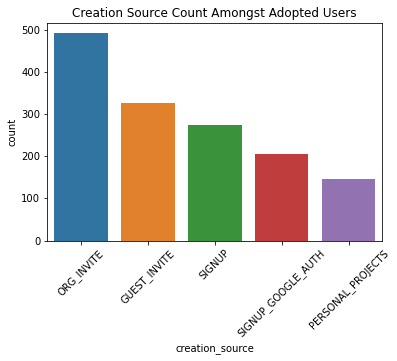

In [17]:
sns.countplot(data = adopted, x = 'creation_source', order = source_list)
plt.tick_params(axis='x', rotation=45)
plt.title('Creation Source Count Amongst Adopted Users')

Text(0.5, 1.0, 'Creation Source Count Amongst Not Adopted Users')

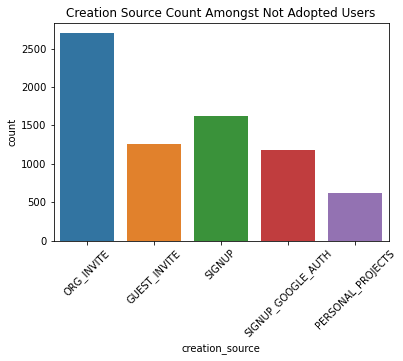

In [18]:
sns.countplot(data = not_adopted, x = 'creation_source', order = source_list)
plt.tick_params(axis='x', rotation=45)
plt.title('Creation Source Count Amongst Not Adopted Users')

There doesn't seem to be much different in the distribution of creation sources between adopted and non adopted users. The graph indicates that non adopted users are less often invited by guests relative to the other categories.

([<matplotlib.axis.XTick at 0x26ee0798708>,
 [Text(0, 0, 'No'), Text(0, 0, 'Yes')])

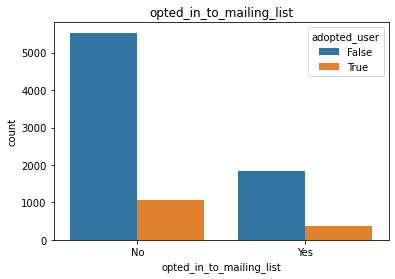

In [19]:
sns.countplot(data = data, x = 'opted_in_to_mailing_list', hue = 'adopted_user')
plt.tick_params(axis='x')
plt.title('opted_in_to_mailing_list')
plt.xticks([0,1],['No', 'Yes'])

([<matplotlib.axis.XTick at 0x26ee07a2688>,
 [Text(0, 0, 'No'), Text(0, 0, 'Yes')])

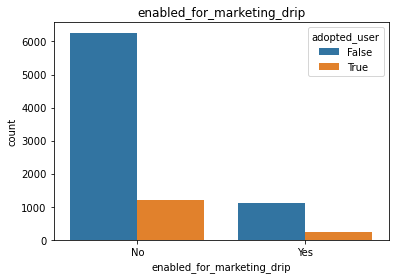

In [20]:
sns.countplot(data = data, x = 'enabled_for_marketing_drip', hue = 'adopted_user')
plt.tick_params(axis='x')
plt.title('enabled_for_marketing_drip')
plt.xticks([0,1],['No', 'Yes'])

Visualizations indicate no difference in the ratios of of adopted and non adopted users who opted into the mailing list and are receiving emails.

In [21]:
adopted['org_id'].value_counts()

7      16
1      14
13     13
9      13
3      13
       ..
259     1
376     1
223     1
379     1
228     1
Name: org_id, Length: 396, dtype: int64

Text(0.5, 1.0, 'Adopted users by organization')

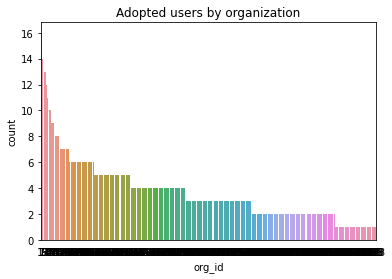

In [146]:
sns.countplot(data = adopted, x = 'org_id', order = org_list).tick_params(bottom = False)
plt.title('Adopted users by organization')

Text(0.5, 1.0, 'Not adopted users by organization')

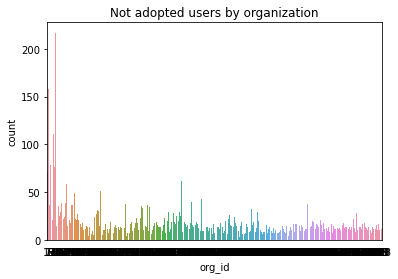

In [145]:
sns.countplot(data = not_adopted, x = 'org_id', order = org_list).tick_params(bottom = False)
plt.title('Not adopted users by organization')

There are hundreds of different organizations that use the platfrom and there is no distinguishable relationship that can be discerned. Some organizations significantly use the platform more often than the rest.

# Modeling and Training

Given the large amount of categorical variables I believe it makes sense to use a randomforest classifier to predict whether or not a user will adopt the platform. In the following cells I will create a clean dataset for training and modeling. This will involve removing columns with no information, turning the categorical variables into dummies, and scaling the numerical variables so they are weighted equally.

In [111]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix
from sklearn.preprocessing import MinMaxScaler

In [77]:
data_clean = data.copy()
data_clean

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,creation_date,time_stamp,visited,days_since_last_session,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22,1,0,11,10803.0,4-2014,2014-04-27,1,-45,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31,0,0,1,316.0,11-2013,2014-04-06,3,-67,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19,0,0,94,1525.0,3-2013,2013-03-24,1,-444,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22,0,0,1,5151.0,5-2013,2013-05-26,1,-380,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22,0,0,193,5240.0,1-2013,2013-01-27,1,-500,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8818,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,2013-09-06,0,0,89,8263.0,9-2013,2013-09-08,1,-273,False
8819,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,2013-01-15,0,0,200,NaN,1-2013,2013-01-20,1,-507,False
8820,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,2014-04-27,1,1,83,8074.0,4-2014,2014-04-27,1,-40,False
8821,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,2012-06-02,0,0,6,NaN,5-2012,2012-06-03,1,-734,False


In [78]:
data_clean = data_clean.drop(['object_id', 'creation_time', 'name', 'email', 'last_session_creation_time', 'time_stamp', 'visited'], axis = 1)


data_clean = pd.get_dummies(data_clean, columns = ['creation_source', 'opted_in_to_mailing_list', 'org_id', 'invited_by_user_id', 'creation_date', 'enabled_for_marketing_drip', 'org_id'])

scale_variables = ['days_since_last_session']
scaler = MinMaxScaler()
data_clean[scale_variables] = scaler.fit_transform(data_clean[scale_variables])

In [82]:
data_clean

,days_since_last_session,adopted_user,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,opted_in_to_mailing_list_0,opted_in_to_mailing_list_1,org_id_0,...,org_id_407,org_id_408,org_id_409,org_id_410,org_id_411,org_id_412,org_id_413,org_id_414,org_id_415,org_id_416
0,0.938859,False,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0.908967,True,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.396739,False,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.483696,False,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.320652,False,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8818,0.629076,False,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8819,0.311141,False,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8820,0.945652,False,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8821,0.002717,False,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


With the data cleaned i split the data up into X and y for my independent and dependent variables respectively and split those variables up into trainig and testing sets for training and validation. I then iterate over a few lists with varying randomforest parameters in order to find a model which gets the best test results based on the confusion matrix ocnstructed for each model. 

In [85]:
X = data_clean.drop('adopted_user', axis = 1)
y = data_clean['adopted_user'].apply(lambda x: 0 if x == False else 1)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .2)

In [94]:
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(X_train, y_train)
predictions = rf.predict(X_train)

Accuracy with max features = 1 and max depth = None: 0.8668555240793201


<Figure size 432x288 with 0 Axes>

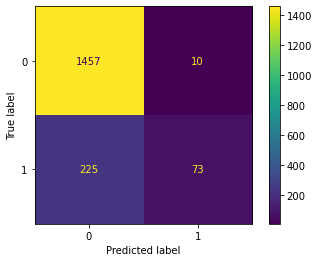

Accuracy with max features = 1 and max depth = 2: 0.18073654390934843


<Figure size 432x288 with 0 Axes>

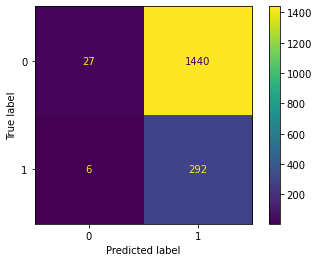

Accuracy with max features = 1 and max depth = 3: 0.8192634560906515


<Figure size 432x288 with 0 Axes>

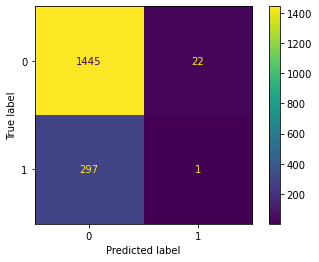

Accuracy with max features = 1 and max depth = 4: 0.8271954674220963


<Figure size 432x288 with 0 Axes>

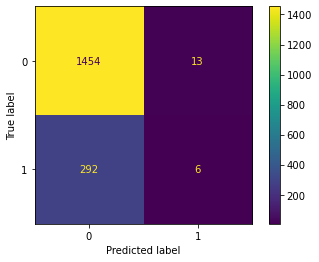

Accuracy with max features = 1 and max depth = 5: 0.1813031161473088


<Figure size 432x288 with 0 Axes>

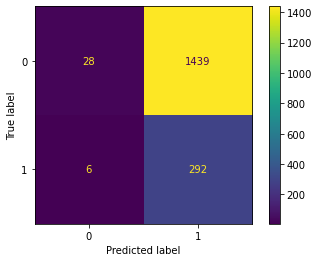

Accuracy with max features = sqrt and max depth = None: 0.9467422096317281


<Figure size 432x288 with 0 Axes>

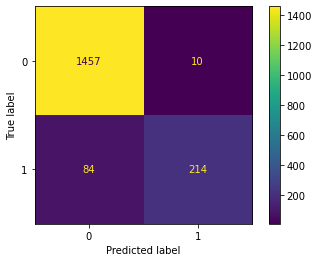

Accuracy with max features = sqrt and max depth = 2: 0.7025495750708215


<Figure size 432x288 with 0 Axes>

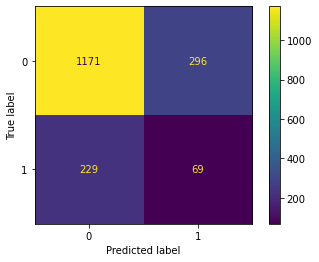

Accuracy with max features = sqrt and max depth = 3: 0.7546742209631728


<Figure size 432x288 with 0 Axes>

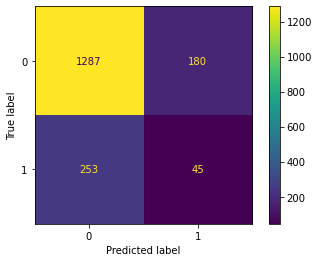

Accuracy with max features = sqrt and max depth = 4: 0.23512747875354106


<Figure size 432x288 with 0 Axes>

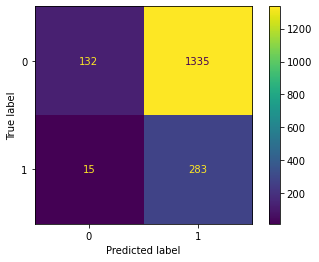

Accuracy with max features = sqrt and max depth = 5: 0.3008498583569405


<Figure size 432x288 with 0 Axes>

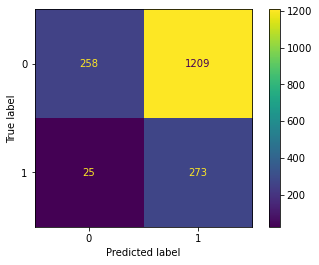

Accuracy with max features = log2 and max depth = None: 0.909915014164306


<Figure size 432x288 with 0 Axes>

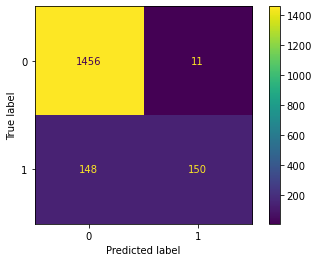

Accuracy with max features = log2 and max depth = 2: 0.19603399433427762


<Figure size 432x288 with 0 Axes>

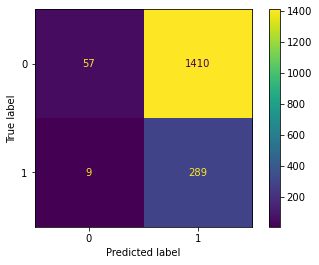

Accuracy with max features = log2 and max depth = 3: 0.8260623229461757


<Figure size 432x288 with 0 Axes>

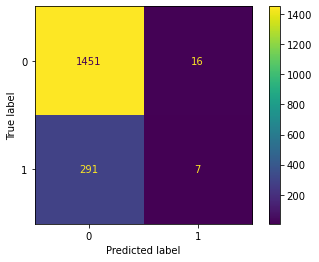

Accuracy with max features = log2 and max depth = 4: 0.7070821529745043


<Figure size 432x288 with 0 Axes>

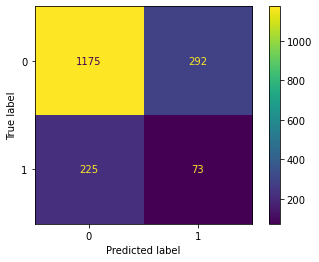

Accuracy with max features = log2 and max depth = 5: 0.8951841359773371


<Figure size 432x288 with 0 Axes>

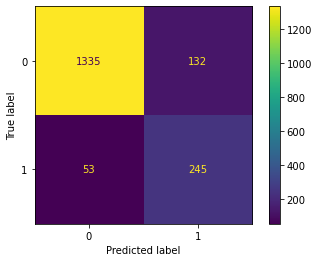

In [123]:
from itertools import product
max_features = [1, 'sqrt', 'log2']
max_depths = [None, 2, 3, 4 , 5]

for f, d in product(max_features, max_depths):
    rf = RandomForestClassifier(n_estimators = 10,criterion = 'entropy', max_features = f, max_depth = d, class_weight = 'balanced')
    rf.fit(X_train, y_train)
    prediction = rf.predict(X_test)
    print('Accuracy with max features = {} and max depth = {}: {}'.format(f, d, accuracy_score(y_test, prediction)))
    cm = confusion_matrix(y_test, prediction)
    cm_norm = cm/cm.sum(axis = 1)[:, np.newaxis]
    plt.figure()
    plot_confusion_matrix(rf, X_test, y_test)
    plt.show()

In [125]:
y_test.value_counts()

0    1467
1     298
Name: adopted_user, dtype: int64

In [148]:
# Used this cell to compare accuracy within adopted and non adopted users respectively
print(1335/1467, 245/298)

0.9100204498977505 0.8221476510067114


Based on these confusion matrices, the most useful model appears to be the model with max_Features = log2 and max_depth = 5. I made this decision based on the models ability to identify aa significant amount of adopted users (82%) while also accurately identifying non adopted users (91%). It is possible that another model has a larger total accuracy but failed to distinguish between adopted and non adopted users in a manner which is useful. Below I will reproduce a random forest model with similar parameters and identify which features allowed it to make its decisions.  

Accuracy with max features = log2 and max depth = 5: 0.9008498583569405


<Figure size 432x288 with 0 Axes>

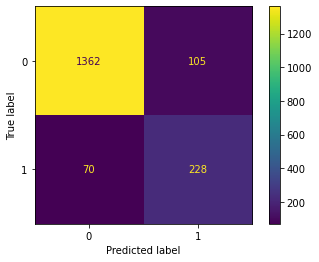

In [149]:
rf = RandomForestClassifier(n_estimators = 10,criterion = 'entropy', max_features = 'log2', max_depth = 5, class_weight = 'balanced')
rf.fit(X_train, y_train)
prediction = rf.predict(X_test)
print('Accuracy with max features = {} and max depth = {}: {}'.format(f, d, accuracy_score(y_test, prediction)))
cm = confusion_matrix(y_test, prediction)
cm_norm = cm/cm.sum(axis = 1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(rf, X_test, y_test)

In [133]:
fi = pd.DataFrame(columns = ['Feature', 'Importance'])

In [140]:
fi = pd.DataFrame(columns = ['Feature', 'Importance'])
for i, column in enumerate(X):
    fi = fi.append({'Feature' : column, 'Importance' : rf.feature_importances_[i]}, ignore_index = True)

In [144]:
fi.sort_values('Importance', ascending = False).head(50)

,Feature,Importance
0,days_since_last_session,0.448237
2670,creation_date_5-2014,0.052562
2667,creation_date_4-2014,0.012264
2665,creation_date_3-2014,0.007681
6,opted_in_to_mailing_list_0,0.006998
7,opted_in_to_mailing_list_1,0.006909
2,creation_source_ORG_INVITE,0.006535
4,creation_source_SIGNUP,0.006440
5,creation_source_SIGNUP_GOOGLE_AUTH,0.005709
2673,creation_date_7-2012,0.005571


The dataframe above has been listed in descending order of the model's feature importance. The most significant feature is clearly days_since_last_session follwoed by several monthly categories. This indicates that the time a user begins using the program is a large determinant of whether or not they become an adopted user. I would assume that this is likely because most recent users don't have time to familiarize themselves with the product and become adopted users. Another model might need to be run to see how well it can perform without timing factors.Besides date variables, the creation source seems to have a significant affect, and certain organizations also seem to be useful factors for predicting adoption. It is possible that these organizations have a significant demand for the product and identifying these organizations may be useful for further research into what causes adoption.